# 1.0 Setup

## 1.1 Install Required Packages
Needs to run only once. Checks if its installed else skips it for much faster resets

In [1]:
try:
    import torch
    import tqdm

except NameError:
    !pip install torch
    !pip install tqdm
    !pip install seaborn

## 1.2 Import Libraries

In [2]:
import os
import csv
import random
import logging
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score, f1_score

## 1.3 Enviroment Settings

In [3]:
# Run
SEED = 22
FOLD = 0

# Set number of concurrent threads. For Kaggle TPU, the maxmimum is 96.
PROCESSES = 4

In [4]:
# Filepaths
OUTPUT_FOLDER = f'/kaggle/working/fold_{FOLD}' 
LOG_OUTPUT = OUTPUT_FOLDER + f'/fold-{FOLD}-merge.log'

# Load Dataframe
TRAIN_RESULTS = pd.read_csv(f"/kaggle/input/twitter-xlm-roberta-base-varentropy/fold_{FOLD}/train-predictions-raw.csv")
VAL_RESULTS = pd.read_csv(f"/kaggle/input/twitter-xlm-roberta-base-varentropy/fold_{FOLD}/val-predictions-raw.csv")
TEST_RESULTS = pd.read_csv(f"/kaggle/input/twitter-xlm-roberta-base-varentropy/fold_{FOLD}/test-predictions-raw.csv")
TSV = '/kaggle/input/small-project/small-project/IEMOCAP_4.tsv'

# Merge Train and Val into single dataframe for hopefully better parameter searching
TRAIN_VAL_RESULTS = pd.concat([TRAIN_RESULTS, VAL_RESULTS], ignore_index=True)

In [5]:
def setup_seed(seed=2021):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [6]:
def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter("[%(asctime)s][%(filename)s][line:%(lineno)d][%(levelname)s] %(message)s")
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])

    fh = logging.FileHandler(filename, "w")
    fh.setFormatter(formatter)                                                                                                                                                                                     
    logger.addHandler(fh)                                                                                                                                                                                          
                                                                                                                                                                                                                   
    sh = logging.StreamHandler()                                                                                                                                                                                   
    sh.setFormatter(formatter)                                                                                                                                                                                     
    logger.addHandler(sh)                                                                                                                                                                                          
                                                                                                                                                                                                                   
    return logger

setup_seed(SEED)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
logger = get_logger(LOG_OUTPUT)

In [7]:
logger.info(f"---- Fold Details ----")
logger.info(f"Train: {len(TRAIN_RESULTS)}")
logger.info(f"Val:   {len(VAL_RESULTS)}")
logger.info(f"Test:  {len(TEST_RESULTS)}")
logger.info(f"Train + Val: {len(TRAIN_VAL_RESULTS)}")

[2025-06-16 11:43:11,894][1735818808.py][line:1][INFO] ---- Fold Details ----
[2025-06-16 11:43:11,895][1735818808.py][line:2][INFO] Train: 4446
[2025-06-16 11:43:11,897][1735818808.py][line:3][INFO] Val:   557
[2025-06-16 11:43:11,898][1735818808.py][line:4][INFO] Test:  528
[2025-06-16 11:43:11,899][1735818808.py][line:5][INFO] Train + Val: 5003


# 2.0 Calculate per-class values for Varentropy and Entropy

In [8]:
# A dictionary to store all important values for easier analysis later
consolidated_results = {
    "original_trainval_accuracy": 0.0,
    "original_test_accuracy": 0.0,
}

## 2.1 Obtain the baseline results for Train+Val and Test Splits

In [9]:
# Remap predicted class numbers (0–3) to labels (A/H/N/S)
remap_dict = {0: 'A', 1: 'H', 2: 'N', 3: 'S'}

# Run twice for each split
for split in ["Test", "Train+Val"]:

    if split == "Train+Val":
        dataframe = TRAIN_VAL_RESULTS
    elif split == "Test":
        dataframe = TEST_RESULTS
    else:
        raise Exception("Unknown Split!")
    
    dataframe['pred_label'] = dataframe['class'].map(remap_dict)

    # Load true labels
    true_df = pd.read_csv(TSV, sep='\t')
    
    # Merge predictions with ground truth labels
    merged = pd.merge(dataframe, true_df[['filename', 'label']], left_on='ID', right_on='filename')

    if split == "Train+Val":
        merged = pd.merge(dataframe, true_df[['filename', 'label']], left_on='ID', right_on='filename')
        merged['is_correct'] = merged['pred_label'] == merged['label']
    elif split == "Test":
        merged_test = pd.merge(dataframe, true_df[['filename', 'label']], left_on='ID', right_on='filename')
        merged_test['is_correct'] = merged_test['pred_label'] == merged_test['label']
    else:
        raise Exception("Unknown Split!")
    
    # Mark predictions as correct or not
    merged['is_correct'] = merged['pred_label'] == merged['label']
    
    # Calculate macro recall
    y_true = merged['label']
    y_pred = merged['pred_label']
    
    # Compute UA score
    macro_recall = recall_score(y_true, y_pred, average='macro')
    average_recall = recall_score(y_true, y_pred, average='weighted')

    # Save the score
    if split == "Train+Val":
        consolidated_results["original_trainval_accuracy"] = macro_recall
    elif split == "Test":
        consolidated_results["original_test_accuracy"] = macro_recall
    
    # Print Test UA (macro recall)
    logger.info(f"[Split: {split}] Test UA (Macro Recall): {macro_recall:.4f} <- Cross reference this with previous folds to confirm that the boxplot is plotted correctly!")

[2025-06-16 11:43:11,981][3189934440.py][line:49][INFO] [Split: Test] Test UA (Macro Recall): 0.7104 <- Cross reference this with previous folds to confirm that the boxplot is plotted correctly!
[2025-06-16 11:43:12,068][3189934440.py][line:49][INFO] [Split: Train+Val] Test UA (Macro Recall): 0.8404 <- Cross reference this with previous folds to confirm that the boxplot is plotted correctly!


### Display Varentropy Results

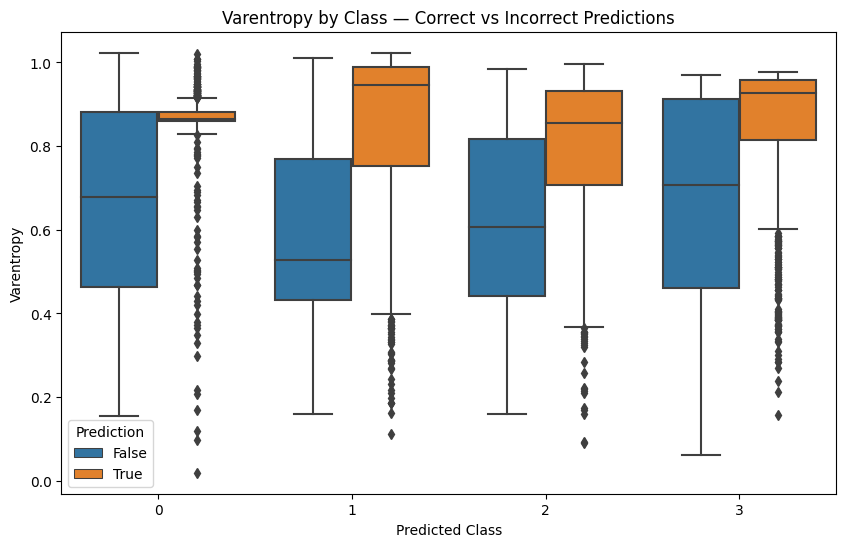

In [10]:
# Plot boxplot per class with correct/incorrect shown by color
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged, x='class', y='varentropy', hue='is_correct')
plt.title('Varentropy by Class — Correct vs Incorrect Predictions')
plt.xlabel('Predicted Class')
plt.ylabel('Varentropy')
plt.legend(title='Prediction')
plt.savefig(f"{OUTPUT_FOLDER}/fold_{FOLD}_varentropy_boxplot.png", dpi=300, bbox_inches='tight')  # Save figure
plt.show()

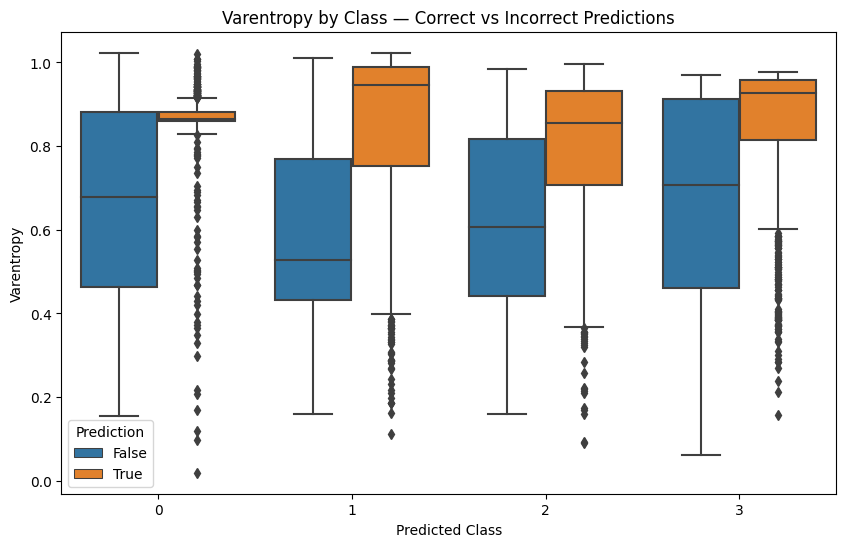

In [11]:
# Plot boxplot per class with correct/incorrect shown by color
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged, x='class', y='varentropy', hue='is_correct')
plt.title('Varentropy by Class — Correct vs Incorrect Predictions')
plt.xlabel('Predicted Class')
plt.ylabel('Varentropy')
plt.legend(title='Prediction')
plt.savefig(f"{OUTPUT_FOLDER}/fold_{FOLD}_varentropy_boxplot.png", dpi=300, bbox_inches='tight')  # Save figure
plt.show()

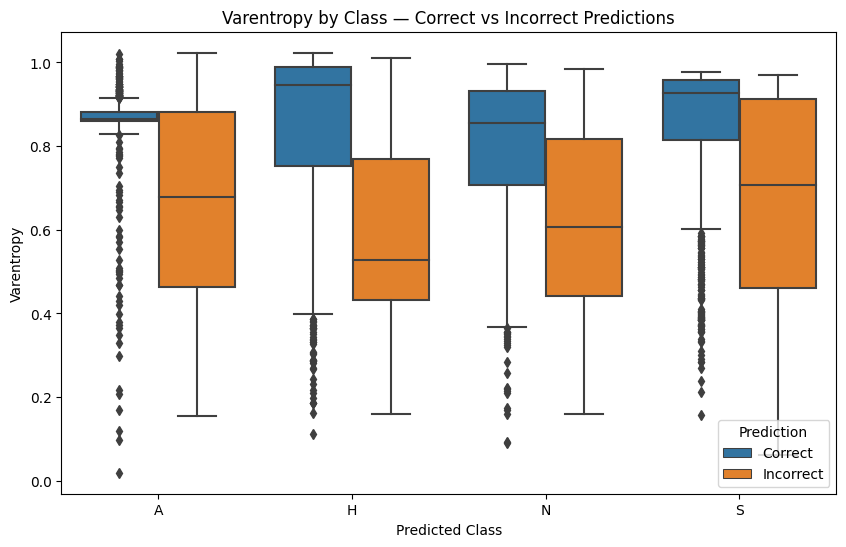

In [12]:
# Plot boxplot per class with correct/incorrect shown by color
#plt.figure(figsize=(10, 6))
#sns.boxplot(data=merged, x='class', y='varentropy', hue='is_correct')
#plt.title('Varentropy by Class — Correct vs Incorrect Predictions')
#plt.xlabel('Predicted Class')
#plt.ylabel('Varentropy')
#plt.legend(title='Prediction')
#plt.savefig(f"{OUTPUT_FOLDER}/fold_{FOLD}_varentropy_boxplot.png", dpi=300, bbox_inches='tight')  # Save figure
#plt.show()

# Remap class labels
remap_dict = {0: 'A', 1: 'H', 2: 'N', 3: 'S'}
merged['class_label'] = merged['class'].map(remap_dict)

# Ensure correct order on x-axis
ordered_classes = ['A', 'H', 'N', 'S']

# Remap True/False to Correct/Incorrect
merged['is_correct_label'] = merged['is_correct'].map({True: 'Correct', False: 'Incorrect'})

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged, x='class_label', y='varentropy', hue='is_correct_label', order=ordered_classes)
plt.title('Varentropy by Class — Correct vs Incorrect Predictions')
plt.xlabel('Predicted Class')
plt.ylabel('Varentropy')

# Move legend inside plot, aligned to top right
plt.legend(title='Prediction', loc='lower right', frameon=True)

plt.savefig(f"{OUTPUT_FOLDER}/fold_{FOLD}_varentropy_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

### Display Entropy Results

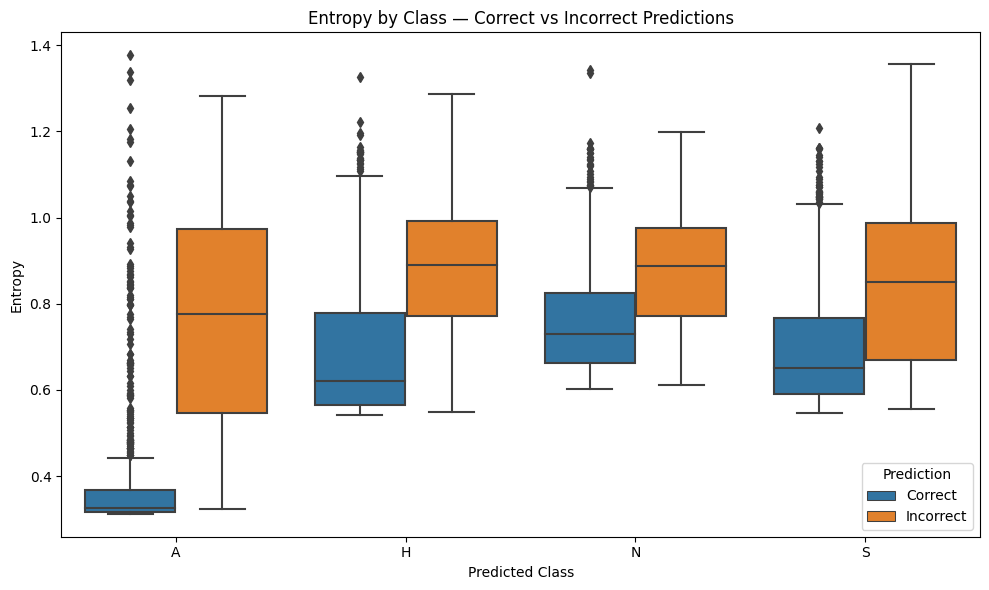

In [13]:
# Plot boxplot per class using 'entropy' instead of 'varentropy'
#plt.figure(figsize=(10, 6))
#sns.boxplot(data=merged, x='class', y='entropy', hue='is_correct')
#plt.title('Entropy by Class — Correct vs Incorrect Predictions')
#plt.xlabel('Predicted Class')
#plt.ylabel('Entropy')
#plt.legend(title='Prediction')
#plt.savefig(f"{OUTPUT_FOLDER}/fold_{FOLD}_entropy_boxplot.png", dpi=300, bbox_inches='tight')  # Save figure
#plt.show()

# Remap class labels
remap_dict = {0: 'A', 1: 'H', 2: 'N', 3: 'S'}
merged['class_label'] = merged['class'].map(remap_dict)

# Ensure correct order on x-axis
ordered_classes = ['A', 'H', 'N', 'S']

# Remap True/False to Correct/Incorrect
merged['is_correct_label'] = merged['is_correct'].map({True: 'Correct', False: 'Incorrect'})

# Plot boxplot per class using 'entropy'
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged, x='class_label', y='entropy', hue='is_correct_label', order=ordered_classes)
plt.title('Entropy by Class — Correct vs Incorrect Predictions')
plt.xlabel('Predicted Class')
plt.ylabel('Entropy')

# Move legend inside plot to bottom right
plt.legend(title='Prediction', loc='lower right', frameon=True)

plt.tight_layout()
plt.savefig(f"{OUTPUT_FOLDER}/fold_{FOLD}_entropy_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

### Confusion Matrix

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['A', 'H', 'N', 'S'])

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A', 'H', 'N', 'S'], yticklabels=['A', 'H', 'N', 'S'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(f"{OUTPUT_FOLDER}/fold_{FOLD}_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

### Save the results for use later during parameter search
Everything related to original accuracy can be accessed via this dictionary eg. `original_accuracy['class_0']`

In [ ]:
# Compute per-class accuracy
accuracy_per_class = (
    merged.groupby('class')['is_correct']
    .mean()
    .rename('accuracy')
    .reset_index()
)

# Create dictionary with keys like 'class_0'
original_accuracy = {
    f'class_{int(row["class"])}': row['accuracy']
    for _, row in accuracy_per_class.iterrows()
}

# Add Original accuracy
original_accuracy['train_val_accuracy_ua'] = macro_recall
original_accuracy['train_val_accuracy_war'] = average_recall

logger.info(f"Per Class Original Accurcy:")
logger.info(f"Class 0:  {original_accuracy['class_0']:.4f}")
logger.info(f"Class 1:  {original_accuracy['class_1']:.4f}")
logger.info(f"Class 2:  {original_accuracy['class_2']:.4f}")
logger.info(f"Class 3:  {original_accuracy['class_3']:.4f}")
logger.info(f"Test UA:  {original_accuracy['train_val_accuracy_ua']:.4f}")

## Basic Threshold Settings

In [ ]:
# Values of 0 to 1
sentiment_start = 0.0
sentiment_stop = 0.7
sentiment_step = 0.05

# For varentropy and entropy. Total combinations is (NUM_STEPS*2 x Sentiment Range) x4
NUM_STEPS = 200

# Search Options
flip_options = [True, False]
merge_options = ['ignore-when-match']
sentiment_options = ['simple', 'refer']

## Set Varentropy Ranges

In [ ]:
# Filter for incorrect predictions
incorrect_preds = merged[merged['is_correct'] == False]

range_lower = 0.35
range_upper = 0.15

# Group by predicted class and calculate summary stats for varentropy
grouped = incorrect_preds.groupby('class')['varentropy']

min_varentropy = grouped.min().to_dict()
max_varentropy = grouped.max().to_dict()
avg_varentropy = grouped.mean().to_dict()
lower_varentropy = grouped.quantile(range_lower).to_dict()
upper_varentropy = grouped.quantile(range_upper).to_dict()

# Generate 5 evenly spaced thresholds for each class
varentropy_thresholds = {}  # Dict[class] = [list of 5 thresholds]

for cls in lower_varentropy:
    lower = lower_varentropy[cls]
    upper = upper_varentropy[cls]
    if upper < lower:
        thresholds = np.linspace(upper, lower, NUM_STEPS).tolist()
    else:
        thresholds = [lower]  # fallback if there's no range
    varentropy_thresholds[cls] = thresholds

# Optional: Print them to inspect
logger.info(f"Varentropy Search Parameters:")

# Loop over classes (Either upper or lower will get the same result)
for cls in lower_varentropy:
    lower = lower_varentropy.get(cls)
    upper = upper_varentropy.get(cls)
    logger.info(f"Class {cls}: {lower:.4f} to {upper:.4f} in {len(varentropy_thresholds[cls])} Steps")

## Set Entropy Ranges

In [ ]:
range_lower = 0.65
range_upper = 0.85

# Group by predicted class and calculate summary stats for varentropy
grouped = incorrect_preds.groupby('class')['entropy']

min_entropy = grouped.min().to_dict()
max_entropy = grouped.max().to_dict()
avg_entropy = grouped.mean().to_dict()
lower_entropy = grouped.quantile(range_lower).to_dict()
upper_entropy = grouped.quantile(range_upper).to_dict()

# Generate 5 evenly spaced thresholds for each class
entropy_thresholds = {}  # Dict[class] = [list of 5 thresholds]

for cls in lower_entropy:
    lower = lower_entropy[cls]
    upper = upper_entropy[cls]
    if upper > lower:
        thresholds = np.linspace(lower, upper, NUM_STEPS).tolist()
    else:
        thresholds = [lower]  # fallback if there's no range
    entropy_thresholds[cls] = thresholds

# Optional: Print them to inspect
logger.info(f"Entropy Search Parameters:")

# Loop over classes (Either upper or lower will get the same result)
for cls in lower_entropy:
    lower = lower_entropy.get(cls)
    upper = upper_entropy.get(cls)
    logger.info(f"Class {cls}: {lower:.4f} to {upper:.4f} in {len(entropy_thresholds[cls])} Steps")

In [ ]:
# Log Total Combinations
sentiment_threshold_range = np.arange(sentiment_start , sentiment_stop + sentiment_step , sentiment_step)
logger.info(f"Sentiment Parameters: {sentiment_start} To {sentiment_stop} in steps of {sentiment_step}")
logger.info(f"Total Unique Combinations: {NUM_STEPS*2*(len(sentiment_threshold_range))*4}")

# Main Program

### Create all required dataframes

In [ ]:
# Create a new copy of the merged train + val dataset
train_val_dataframe = merged.copy() 
test_dataframe = merged_test.copy()

# Drop unused columns
train_val_dataframe = train_val_dataframe.drop(['transcription', 'transcription_nlp','filename'], axis=1)
test_dataframe = test_dataframe.drop(['transcription', 'transcription_nlp','filename'], axis=1)

# Create the per-class dataframes
class_dataframes = {
    0: train_val_dataframe[train_val_dataframe['class'] == 0].copy(),
    1: train_val_dataframe[train_val_dataframe['class'] == 1].copy(),
    2: train_val_dataframe[train_val_dataframe['class'] == 2].copy(),
    3: train_val_dataframe[train_val_dataframe['class'] == 3].copy()
}

# Create the per-class dataframes
test_class_dataframes = {
    0: test_dataframe[test_dataframe['class'] == 0].copy(),
    1: test_dataframe[test_dataframe['class'] == 1].copy(),
    2: test_dataframe[test_dataframe['class'] == 2].copy(),
    3: test_dataframe[test_dataframe['class'] == 3].copy()
}

logger.info(f"----- Train + Val Split Details -----")
logger.info(f"Total Rows: {len(train_val_dataframe)}")
logger.info(f"Class 0: {len(class_dataframes[0])}")
logger.info(f"Class 1: {len(class_dataframes[1])}")
logger.info(f"Class 2: {len(class_dataframes[2])}")
logger.info(f"Class 3: {len(class_dataframes[3])}")

logger.info(f"----- Test Split Details -----")
logger.info(f"Total Rows: {len(test_dataframe)}")
logger.info(f"Class 0: {len(test_class_dataframes[0])}")
logger.info(f"Class 1: {len(test_class_dataframes[1])}")
logger.info(f"Class 2: {len(test_class_dataframes[2])}")
logger.info(f"Class 3: {len(test_class_dataframes[3])}")

class_dataframes[0].sample(5)

## Search Sequence
1. `check_threshold()`
    - For each row, check if BOTH Entropy and Varentropy thresholds are met (IE. most likely the predictions are wrong).
    - Each class has its own Entropy and Varentropy values.

## Pre-Search Details
Using a given set of search parameters, identify if the threshold values are good, or more can be done

In [ ]:
def parameter_analysis(class_id, dataframe, threshold_id=0, entropy_threshold=0, varentropy_threshold=0):

    threshold_counts = 0
    entropy_counts = 0
    varentropy_counts = 0
    success_count = 0

    # Set both threshold to lowest by default if no threshold was given
    if entropy_threshold == 0 or varentropy_threshold == 0:
        
        entropy_threshold = entropy_thresholds[class_id][threshold_id]
        varentropy_threshold = varentropy_thresholds[class_id][threshold_id]
    
    # For each row in each class
    for index, row in dataframe.iterrows():

        # Increment corresponding counter if one or both thresholds have been met
        if row['entropy'] >= entropy_threshold:
            entropy_counts += 1
            
        if row['varentropy'] <= varentropy_threshold:
            varentropy_counts += 1

        if row['entropy'] >= entropy_threshold and row['varentropy'] <= varentropy_threshold:
            threshold_counts += 1

            # Check if the hit was correct in identifying a wrongly classified label
            if row['pred_label'] != row['label']:
                success_count += 1
                
    accuracy = (success_count/threshold_counts) * 100
            
    logger.info(f"Entropy Hits:    {entropy_counts}")
    logger.info(f"Varentropy Hits: {varentropy_counts}")
    logger.info(f"Both Hits:       {threshold_counts}")

    # Optional returns, usually not used
    return [success_count, threshold_counts, accuracy]

## Get a Baseline rate of the current choice of parameters
We set our baseline as the median value of all parameters to be searched

In [ ]:
# Create the per-class dataframes
baseline_hit_rate = {
    0: [],
    1: [],
    2: [],
    3: []
}

# Loop through each per-class dataframe
for class_id, dataframe in class_dataframes.items():
    logger.info(f"------ Class {class_id} ------")

    # Get the middle value of the entire search range, and use that as the baseline
    median_index = int(len(entropy_thresholds[class_id])/2)

    # Save the baseline
    baseline_hit_rate[class_id] = parameter_analysis(class_id, dataframe, threshold_id=median_index)
    logger.info(f"Success Rate:    {baseline_hit_rate[class_id][0]} of {baseline_hit_rate[class_id][1]} ({baseline_hit_rate[class_id][2]:.2f}%)")

## Perform Parameter Search Based on Hit Rate as Metric
The idea here is instead of using the accuracy at the end of the full pipeline (ie. after merging) we use the number of successfully identified incorrect predictions in order to generalise better from train+val to test dataset

In [ ]:
def evaluate_threshold(threshold_pair, dataframe, metric):

    # Split threshold pair
    e_thresh, v_thresh = threshold_pair

    # Get score according to requested metric
    if metric == "f1":
        preds = (dataframe['entropy'] >= e_thresh) & (dataframe['varentropy'] <= v_thresh)
        score = f1_score(~dataframe['is_correct'], preds)

    elif metric == "accuracy":
        
        # Boolean masks
        entropy_mask = dataframe['entropy'] >= e_thresh
        varentropy_mask = dataframe['varentropy'] <= v_thresh
        combined_mask = entropy_mask & varentropy_mask
        misclassified_mask = dataframe['pred_label'] != dataframe['label']
        
        # Counts
        entropy_counts = entropy_mask.sum()
        varentropy_counts = varentropy_mask.sum()
        threshold_counts = combined_mask.sum()
        success_count = (combined_mask & misclassified_mask).sum()

        score = (success_count/threshold_counts) * 100
        
        # For Debug: Print each row and check scores
        #logger.info(f"Entropy hits: {entropy_counts}, Varentropy hits: {varentropy_counts}, Combined: {threshold_counts}, Successes: {success_count}, Accuracy: {score:.4f}")

        
    # For Debug: Print each row and check scores
    #logger.info(f"Thresholds: (entropy >= {e_thresh}, varentropy <= {v_thresh}) → Score: {score:.4f}")
    
    return (e_thresh, v_thresh, score)

In [ ]:
best_parameters = {
    0: [],
    1: [],
    2: [],
    3: []
}

# Iterate over each class
for class_id, dataframe in class_dataframes.items():

    ent_thresholds = entropy_thresholds[class_id]
    var_thresholds = varentropy_thresholds[class_id]
    threshold_pairs = [(e, v) for e in ent_thresholds for v in var_thresholds]
    evaluation_metric = "accuracy"

    results = []
    with ProcessPoolExecutor() as executor:
    #with ProcessPoolExecutor(max_workers=PROCESSES) as executor:
        futures = [executor.submit(evaluate_threshold, pair, dataframe, evaluation_metric) for pair in threshold_pairs]
        for f in tqdm(as_completed(futures), total=len(futures), desc=f"Now Searching Class {class_id}"):
            results.append(f.result())

    # Get the corresponding entropy and varentropy of the best scorer
    best_entropy_t, best_varentropy_t, best_score = max(results, key=lambda x: x[2]) 

    # Save the paramers into a dictionary for later use
    best_parameters[class_id] = [best_entropy_t, best_varentropy_t]

    # Display results
    logger.info(f"------ Class {class_id} Search Results ------")
    logger.info(f"Total Rows:      {len(dataframe)}")
    logger.info(f"Best Entropy:    {best_entropy_t:.4f}")
    logger.info(f"Best Varentropy: {best_varentropy_t:.4f}")
    logger.info(f"Best {evaluation_metric} score:   {best_score:.4f}")
    count, total, acc = parameter_analysis(class_id, dataframe, entropy_threshold=best_entropy_t, varentropy_threshold=best_varentropy_t)
    logger.info(f"Success Rate:    {count} of {total} ({acc:.2f}%)")
    logger.info(f"Baseline Rate:   {baseline_hit_rate[class_id][0]} of {baseline_hit_rate[class_id][1]} ({baseline_hit_rate[class_id][2]:.2f}%)")

## Calculate Accuracy Function
It calcuates the TestUA of the provided dataframe, and also provides additional statistics such as improvement and degredations

In [ ]:
def detailed_score(dataframe):
    y_true = dataframe['label']
    y_pred = dataframe['merged_label']

    macro_recall = recall_score(y_true, y_pred, average='macro')
    average_recall = recall_score(y_true, y_pred, average='weighted')

    # Initialize counters
    improvements = 0
    degradations = 0
    wrong_to_wrong = 0
    no_hit = 0
    hit_correct_no_change = 0
    hit_wrong_no_change = 0

    # Setup transitions
    labels = ['A', 'H', 'N', 'S']
    change_details = {
        f"{src}→{dst}": {"better": 0, "worse": 0, "worse_to_worse": 0}
        for src in labels for dst in labels if src != dst
    }

    for _, row in dataframe.iterrows():
        true = row['label']
        original = row['pred_label']
        merged = row['merged_label']

        original_correct = original == true
        merged_correct = merged == true

        # Threshold not hit, no changes made
        if row['threshold'] == False:
            no_hit += 1

        # Threshold hit
        else:
            key = f"{original}→{merged}"
            
            # Threshold hit, but original and merged are the same
            if original == merged:

                if row['is_correct'] == True:
                    hit_correct_no_change += 1
                else: 
                    hit_wrong_no_change += 1
            
            elif not original_correct and merged_correct:
                improvements += 1
                if key in change_details:
                    change_details[key]["better"] += 1

            elif original_correct and not merged_correct:
                degradations += 1
                if key in change_details:
                    change_details[key]["worse"] += 1

            else:  # wrong → different wrong
                wrong_to_wrong += 1
                if key in change_details:
                    change_details[key]["worse_to_worse"] += 1


    # Generate Exclusion List
    exclusion_list = []
    for transition, stats in change_details.items():
        if stats["better"] < stats["worse"]:
            exclusion_list.append(transition)

    return {
        "macro_recall": macro_recall,
        "average_recall": average_recall,
        "improvements": improvements,
        "degradations": degradations,
        "wrong_to_wrong": wrong_to_wrong,
        "no_hit": no_hit,
        "hit_correct_no_change" : hit_correct_no_change,
        "hit_wrong_no_change" : hit_wrong_no_change,
        "threshold_hits": dataframe['threshold'].sum(),
        "change_details": change_details,
        "exclusion_list": exclusion_list
    }

### Simpler function when you just want to know TestUA

In [ ]:
def simple_score(dataframe, target_label, metric):
    y_true = dataframe['label']
    y_pred = dataframe[target_label]

    if metric == 'TestUA':
        macro_recall = recall_score(y_true, y_pred, average='macro')
        average_recall = recall_score(y_true, y_pred, average='weighted')
        return macro_recall

    elif metric == 'accuracy':
        matches = (y_true == y_pred)
        correct = matches.sum()
        total = len(matches)
        wrong = total - correct
        accuracy = (correct / total) * 100

        # Debug prints
        #logger.info(f"[DEBUG] Correct: {correct}")
        #logger.info(f"[DEBUG] Wrong:   {wrong}")
        #logger.info(f"[DEBUG] Total:   {total}")
        #logger.info(f"[DEBUG] Accuracy: {accuracy:.2f}%")

        return accuracy

    elif metric == 'all':
        macro_recall = recall_score(y_true, y_pred, average='macro')
        average_recall = recall_score(y_true, y_pred, average='weighted')
        macro_f1 = f1_score(y_true, y_pred, average='macro')

        return macro_recall, average_recall, macro_f1

    else:
        raise Exception("Unknown Metric!")

## Remap Sentiment Function

In [ ]:
# Remaps the 3 sentiment to the 4 emotions.
def remap_sentiment(row, flip, sentiment_strategy, sentiment_threshold):
    
    sentiment = row['sentiment']
    score = row['sentiment_score']

    # 1-1 Mapping of Neutral and Positive emotions
    if sentiment == 'neutral':
        return 'N' #2
    elif sentiment == 'positive':
        return 'H' #1
        
    else: # Else sentiment is negative
        
        if sentiment_strategy == 'simple': 
            # There can be two possible mapping for negative sentiment.
            # Either to sad or angry.
            if score <= sentiment_threshold:
                return 'A' if not flip else 'S'
            else:
                return 'S' if not flip else 'A'
        
        # If sentiment is negative, refer to orignal model to decidce how to map
        # negative sentiment to both angry or sad
        elif sentiment_strategy == 'refer':
            angry_score = row['0_Score']
            sad_score = row['3_Score']
            if angry_score >= sad_score:
                return 'A'
            else:
                return 'S'
        else:
            raise Exception("Invalid Sentiment Strategy")

## Merge Function
#### 1. Blind Merge
Will simply merge everything. Used when we are searching for the best sentiment value

#### 2. Exclusion Merge
Will only merge when the emotion changes is not on the exclusion list. This is a list of changes (Eg. A>H) that from previous testing is shown to negatively affect result

In [ ]:
def blind_merge(row, sentiment_threshold, flip, merge_strategy, sentiment_strategy):
        
    # Default mode. 2nd model overrides original model
    if merge_strategy == 'default':
        return remap_sentiment(row, flip, sentiment_strategy, sentiment_threshold)

    # If both models predict the same emotion, ignore any thresholds and assume it is correct 
    elif merge_strategy == 'ignore-when-match':

        # Obtain remapped sentiment
        sentiment = remap_sentiment(row, flip, sentiment_strategy, sentiment_threshold)

        # If both models agree on the same emotion
        if sentiment == row['class']:

            # Copy over with no change
            return row['class']

        else: # Prefer model 2 over original model
            return sentiment

    elif merge_strategy == 'choose_2nd_best':
        
        # Extract class scores into a list
        scores = [row[f'{i}_Score'] for i in range(4)]
        
        # Get class indices sorted by score descending
        sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    
        # Pick the second highest scoring class
        second_best_class = sorted_indices[1]

        # Return letters instead of class numbers    
        return remap_dict[second_best_class]
    
    else:
        raise Exception("Invalid Merge Strategy")

In [ ]:
def exclusion_merge(row, sentiment_threshold, flip, merge_strategy, sentiment_strategy, exclusion_list):
    
    original = row['pred_label']

    # Default mode: 2nd model overrides original
    if merge_strategy == 'default':
        new_label = remap_sentiment(row, flip, sentiment_strategy, sentiment_threshold)
        transition = f"{original}→{new_label}"

        if transition in exclusion_list:
            return original
            
        else:
            return new_label

    # Ignore-when-match strategy
    elif merge_strategy == 'ignore-when-match':
        new_label = remap_sentiment(row, flip, sentiment_strategy, sentiment_threshold)
        transition = f"{original}→{new_label}"

        if new_label == original:
            return original
        else:
            if transition in exclusion_list:
                return original
            else:
                return new_label

    # Choose second-best prediction from confidence scores
    elif merge_strategy == 'choose_2nd_best':
        
        # Extract and sort class scores with indices
        scores = [(i, row[f'{i}_Score']) for i in range(4)]
        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

        # Pick the second best class
        new_label = sorted_scores[1][0]
        transition = f"{original}→{new_label}"

        if new_label == original:
            return original
        else:
            if transition in exclusion_list:
                return original
            else:
                print(remap_dict[new_label])
                return remap_dict[new_label]

    else:
        raise Exception("Invalid Merge Strategy")


# Find Optimial value of `Sentiment Threshold` and `Flip` and which strategy to use

## Merge Function
**Only performs one pass with the provided parameters**

Yes the nested for loops are terrible, but its clear what they do

## Main Merge Driver Code

In [ ]:
# Runs a single pass of the merge algorithm based on the provided parameters
def merge(dataframe, parameters):

    # Clear the output column of values
    dataframe['merged_label'] = None

    entropy_threshold = parameters['entropy_threshold']
    varentropy_threshold = parameters['varentropy_threshold']

    # Tag each row with whether it meets the threshold
    dataframe['threshold'] = (dataframe['entropy'] >= entropy_threshold) & (dataframe['varentropy'] <= varentropy_threshold)

    # Iterate over each row
    for idx in dataframe[dataframe['threshold']].index:

        # Get the row values
        row = dataframe.loc[idx]

        # Merge
        dataframe.at[idx, 'merged_label'] = blind_merge(row, 
                                                        parameters['sentiment_threshold'], 
                                                        parameters['flip_state'], 
                                                        parameters['merge_strategy'], 
                                                        parameters['sentiment_strategy'])

        # Fill in rows where threshold wasn't met with original predictions
        dataframe['merged_label'] = dataframe['merged_label'].fillna(dataframe['pred_label'])


    return dataframe

In [ ]:
# Reset best scores and parameters
default_params = {
    'accuracy' : 0.0,
    'entropy_threshold': 0.0,
    'varentropy_threshold': 0.0,
    'sentiment_threshold': 0.0,
    'sentiment_strategy' : '',
    'merge_strategy' : '',
    'flip_state' : False
}

# Reset all stores parameters in a class
def clear_parameters(class_id):
    best_run_parameters[class_id] = [default_params.copy()]

# Each class maps to a list of parameter dictionaries
best_run_parameters = {i: [default_params.copy()] for i in range(4)}

Eg: Access the 2rd entropy_threshold for class 4: `best_run_parameters[4][2]['entropy_threshold']`

## Iterate per-class over all parameters

In [ ]:
# Iterate over each class
for class_id, dataframe in class_dataframes.items():

    logger.info(f"----------------- Class {class_id} -----------------")

    # Check every combination
    for merge_strategy in merge_options:
        for sentiment_strategy in sentiment_options:
            for flip in flip_options:
                for sentiment_threshold in sentiment_threshold_range:
    
                    # Prepare parameters
                    run_parameters = {
                        'entropy_threshold': best_parameters[class_id][0],
                        'varentropy_threshold': best_parameters[class_id][1],
                        'sentiment_threshold': sentiment_threshold,
                        'sentiment_strategy' : sentiment_strategy,
                        'merge_strategy' : merge_strategy,
                        'flip_state' : flip,
                    }

                    # Run a single pass of the merge
                    temp_dataframe = dataframe.copy(deep=True)
                    temp_dataframe = merge(temp_dataframe, run_parameters)
                    accuracy = simple_score(temp_dataframe, 'merged_label', 'accuracy')


                    # If the accuracy is the per-class best so far
                    if accuracy > best_run_parameters[class_id][0]['accuracy']:
                        logger.info(f"New Best Results!: [Accuracy] {accuracy:.2f}% using [Sentiment] {sentiment_threshold:.2f} | {sentiment_strategy} [Merge] {merge_strategy} [Flip] {flip}")
                        
                        # Clear previous entries
                        clear_parameters(class_id)

                        # Add the run accuracy to the parameters list
                        run_parameters['accuracy'] = accuracy
                        
                        # Save
                        best_run_parameters[class_id][0] = run_parameters 
                        

                    elif accuracy == best_run_parameters[class_id][0]['accuracy']:
                        logger.info(f"Identical Results: [Accuracy] {accuracy:.2f}% using [Sentiment] {sentiment_threshold:.2f} | {sentiment_strategy} [Merge] {merge_strategy} [Flip] {flip}")

                        # Add the run accuracy to the parameters list
                        run_parameters['accuracy'] = accuracy

                        # Append to back
                        best_run_parameters[class_id].append(run_parameters)

# Obtain Merge Results on Train + Val Dataset

### Function to print detailed results

In [ ]:
def show_results(full_dataframe):

    result = detailed_score(full_dataframe)
    good_changes = result['improvements'] + result['hit_correct_no_change']
    bad_changes = result['degradations'] + result['wrong_to_wrong'] + result['hit_wrong_no_change']
    success_rate = (good_changes/result['threshold_hits'])*100
    logger.info(f"----------- Parameters -----------")
    logger.info(f"Class 0: [Entropy] {best_parameters[0][0]:.4f} [Varentropy] {best_parameters[0][1]:.4f} [Sentiment] {best_run_parameters[0][0]['sentiment_threshold']:.2f}")
    logger.info(f"Class 1: [Entropy] {best_parameters[1][0]:.4f} [Varentropy] {best_parameters[1][1]:.4f} [Sentiment] {best_run_parameters[1][0]['sentiment_threshold']:.2f}")
    logger.info(f"Class 2: [Entropy] {best_parameters[2][0]:.4f} [Varentropy] {best_parameters[2][1]:.4f} [Sentiment] {best_run_parameters[2][0]['sentiment_threshold']:.2f}")
    logger.info(f"Class 3: [Entropy] {best_parameters[3][0]:.4f} [Varentropy] {best_parameters[3][1]:.4f} [Sentiment] {best_run_parameters[3][0]['sentiment_threshold']:.2f}")
    logger.info(f"---------- Merge Results ---------")
    logger.info(f"TestUA:                {result['macro_recall']:.4f}")
    logger.info(f"Passed Threshold:      {result['no_hit']}")
    logger.info(f"Failed Threshold:      {result['threshold_hits']}")
    logger.info(f"----- Detailed Merge Changes -----")
    logger.info(f"Wrong   → Correct:     {result['improvements']}")
    logger.info(f"Correct → Wrong:       {result['degradations']}")
    logger.info(f"Wrong   → Wrong:       {result['wrong_to_wrong']}")
    logger.info(f"No change (Correct):   {result['hit_correct_no_change']}")
    logger.info(f"No change (Wrong):     {result['hit_wrong_no_change']}")
    logger.info(f"Merge Success Rate:    {good_changes}/{result['threshold_hits']} ({success_rate:.2f}%)")
    logger.info(f"------- Change Breakdown ---------")
    for change, stats in result['change_details'].items():
        logger.info(f"{change}: Better = {stats['better']}, Worse = {stats['worse']}, No Change = {stats['worse_to_worse']}")
    logger.info(f"Exclusion List: {result['exclusion_list']}")
    
    return result

### Code to obtain Exclusion List

In [ ]:
# Perform a deep copy of the original dataframe
temporary_class_dataframes = {k: df.copy(deep=True) for k, df in class_dataframes.items()}

# Iterate over each class
for class_id, dataframe in temporary_class_dataframes.items():

    #Load Parameters
    ent_threshold = best_run_parameters[class_id][0]['entropy_threshold']
    var_threshold = best_run_parameters[class_id][0]['varentropy_threshold']
    sentiment_threshold = best_run_parameters[class_id][0]['sentiment_threshold']
    sentiment_strategy = best_run_parameters[class_id][0]['sentiment_strategy']
    merge_strategy = best_run_parameters[class_id][0]['merge_strategy']
    flip_state = best_run_parameters[class_id][0]['flip_state']
    
    dataframe['merged_label'] = None
    dataframe['threshold'] = (dataframe['entropy'] >= ent_threshold) & (dataframe['varentropy'] <= var_threshold)

    for idx in dataframe[dataframe['threshold']].index:
        row = dataframe.loc[idx]
        dataframe.at[idx, 'merged_label'] = blind_merge(row, sentiment_threshold, flip_state, merge_strategy, sentiment_strategy)

    # Fill in rows where threshold wasn't met with original predictions
    dataframe['merged_label'] = dataframe['merged_label'].fillna(dataframe['pred_label'])

# Merging is done, now to check the scores
full_dataframe = pd.concat(temporary_class_dataframes.values(), ignore_index=True)
testUA = simple_score(full_dataframe, 'pred_label', 'TestUA')
logger.info(f"Before: {testUA:.4f}")
testUA = simple_score(full_dataframe, 'merged_label', 'TestUA')
logger.info(f"After:  {testUA:.4f}")

# Get detailed results
detailed_results = show_results(full_dataframe)

## Obtain the Final Results using Exclusion List (On Train + Val Dataset)

In [ ]:
logger.info(f" ----------- Train + Val Split -----------")
temporary_class_dataframes = {k: df.copy(deep=True) for k, df in class_dataframes.items()}

# Iterate over each class
for class_id, dataframe in temporary_class_dataframes.items():

    #Load Parameters
    ent_threshold = best_run_parameters[class_id][0]['entropy_threshold']
    var_threshold = best_run_parameters[class_id][0]['varentropy_threshold']
    sentiment_threshold = best_run_parameters[class_id][0]['sentiment_threshold']
    sentiment_strategy = best_run_parameters[class_id][0]['sentiment_strategy']
    merge_strategy = best_run_parameters[class_id][0]['merge_strategy']
    flip_state = best_run_parameters[class_id][0]['flip_state']
    
    dataframe['merged_label'] = None
    dataframe['threshold'] = (dataframe['entropy'] >= ent_threshold) & (dataframe['varentropy'] <= var_threshold)

    for idx in dataframe[dataframe['threshold']].index:
        row = dataframe.loc[idx]
        dataframe.at[idx, 'merged_label'] = exclusion_merge(row, sentiment_threshold, flip_state, merge_strategy, sentiment_strategy, detailed_results['exclusion_list'])

    # Fill in rows where threshold wasn't met with original predictions
    dataframe['merged_label'] = dataframe['merged_label'].fillna(dataframe['pred_label'])

# Merging is done, now to check the scores
full_dataframe = pd.concat(temporary_class_dataframes.values(), ignore_index=True)
testUA = simple_score(full_dataframe, 'pred_label', 'TestUA')
logger.info(f"Before: {testUA:.4f}")
testUA = simple_score(full_dataframe, 'merged_label', 'TestUA')
logger.info(f"After:  {testUA:.4f}")

# Get detailed results
_ = show_results(full_dataframe)

## Obtain the Final Results using Exclusion List (On Test Dataset)

In [ ]:
logger.info(f" ----------- Test Split -----------")

# Iterate over each class
for class_id, dataframe in test_class_dataframes.items():

    #Load Parameters
    ent_threshold = best_run_parameters[class_id][0]['entropy_threshold']
    var_threshold = best_run_parameters[class_id][0]['varentropy_threshold']
    sentiment_threshold = best_run_parameters[class_id][0]['sentiment_threshold']
    sentiment_strategy = best_run_parameters[class_id][0]['sentiment_strategy']
    merge_strategy = best_run_parameters[class_id][0]['merge_strategy']
    flip_state = best_run_parameters[class_id][0]['flip_state']
    
    dataframe['merged_label'] = None
    dataframe['threshold'] = (dataframe['entropy'] >= ent_threshold) & (dataframe['varentropy'] <= var_threshold)

    for idx in dataframe[dataframe['threshold']].index:
        row = dataframe.loc[idx]
        dataframe.at[idx, 'merged_label'] = exclusion_merge(row, sentiment_threshold, flip_state, merge_strategy, sentiment_strategy, detailed_results['exclusion_list'])

    # Fill in rows where threshold wasn't met with original predictions
    dataframe['merged_label'] = dataframe['merged_label'].fillna(dataframe['pred_label'])

# Merging is done, now to check the scores
full_dataframe = pd.concat(test_class_dataframes.values(), ignore_index=True)
testUA = simple_score(full_dataframe, 'pred_label', 'TestUA')
logger.info(f"Before: {testUA:.4f}")
testUA = simple_score(full_dataframe, 'merged_label', 'TestUA')
logger.info(f"After:  {testUA:.4f}")

# Additional info on request
logger.info(f"[Additional Comparisons]")
testUA_old, testWA_old, F1_macro_old = simple_score(full_dataframe, 'pred_label', 'all')
testUA_new, testWA_new, F1_macro_new = simple_score(full_dataframe, 'merged_label', 'all')
logger.info(f"TestUA: {testUA_old:.4f} -> {testUA_new:.4f}")
logger.info(f"TestWA: {testWA_old:.4f} -> {testWA_new:.4f}")
logger.info(f"F1:     {F1_macro_old:.4f} -> {F1_macro_new:.4f}")

# Get detailed results
_ = show_results(full_dataframe)